# Set Up

In [1]:
import squidpy as sq

import numpy as np

import seaborn as sns

import scanpy as sc

import pandas as pd

import matplotlib.pyplot as plt

import anndata as ad

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

/home/jovyan/my-conda-envs/sqpy/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.3 pandas==1.5.2 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.2 pynndescent==0.5.8
squidpy==1.2.3


# Read in concatenated slide file

In [2]:
# Read in adata
adata_vis=sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/visium_foetal_raw.h5ad')

# QC and pre-processing

In [3]:
# filtering genes and log-normalise
sc.pp.filter_genes(adata_vis, min_cells=3)
sc.pp.normalize_total(adata_vis, target_sum=1e4)
sc.pp.log1p(adata_vis)

# add cell2loc output to .obs
df = adata_vis.obsm['q05_cell_abundance_w_sf'].copy()
df.columns = [x.replace('q05cell_abundance_w_sf_','') for x in df.columns]
adata_vis.obs[df.columns]=df.copy()

# var.names=SYMBOL
adata_vis.var.set_index('SYMBOL',inplace=True)
adata_vis

AnnData object with n_obs × n_vars = 20975 × 23016
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'n_counts', 'n_genes', 'JC_edit', 'sangerID', 'Foetal_or_Adult', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'AtrialCardiomyocytesCycling', 'AtrialCardiomyocytesLeft', 'AtrialCardiomyocytesRight', 'AtrioventricularNodeCardiomyocytes', 'BCells', 'Cardiofibromyocytes', 'ChromaffinCells', 'CoronaryEndothelialCellsArterial', 'CoronaryEndothelialCellsCapillary', 'CoronaryEndothelialCellsVenous', 'CoronaryPericytes', 'CoronarySmoothMuscleCells', 'CoronaryVesselAdventitialFibroblasts', 'DendriticCells', 'EndocardialCells', 'FibroblasticEpicardialCells', 'GreatVesselAdven

In [5]:
adata_vis.X.data[:10]

array([0.576221 , 0.9394616, 0.9394616, 0.576221 , 0.576221 , 1.2053434,
       0.9394616, 1.415175 , 0.576221 , 0.576221 ], dtype=float32)

# Read in causal gene data

In [73]:
causal_genes=pd.read_csv('/home/jovyan/data/monogenic_disease/concatenated_df.csv',index_col='gene')
causal_genes

CHD classification  \
gene                                                        
AARS2                                                 NaN   
ABCC9                                                 NaN   
ABL1                                              ASD,VSD   
ABL1                                                  NaN   
ACAD9                                                 NaN   
...                                                   ...   
WASHC5  ASD with minor abnormalities,VSD with minor ab...   
ZEB2    ASD with minor abnormalities,VSD with minor ab...   
ZFPM2                      Malformation of outflow tracts   
ZIC3                                                  NaN   
ZIC3    ASD with minor abnormalities,VSD with minor ab...   

       Extra cardiac phenotype Inheritance mode  Ranking  \
gene                                                       
AARS2                      NaN              NaN      NaN   
ABCC9                      NaN              NaN      NaN   
ABL1                       Yes            AD,DN      5.0   
ABL1                       NaN              NaN      NaN   
ACAD9                      NaN              NaN      NaN   
...                        ...              ...      ...   
WASHC5                     Yes               AR      5.0   
ZEB2                       Yes            AD,DN      5.0   
ZFPM2                       No            AD,DN      5.0   
ZIC3                       NaN              NaN      NaN   
ZIC3                       Yes              XLR      5.0   

        Supporting References  phenotype_Heterotaxy  phenotype_ASD  \
gene                                                                 
AARS2                     NaN                     0              0   
ABCC9                     NaN                     0              0   
ABL1                      2.0                     0              1   
ABL1                      NaN                     0              0   
ACAD9                     NaN                     0              0   
...                       ...                   ...            ...   
WASHC5                    2.0                     0              1   
ZEB2                      3.0                     0              1   
ZFPM2                     2.0                     0              0   
ZIC3                      NaN                     1              0   
ZIC3                      5.0                     1              1   

        phenotype_VSD  phenotype_AVSD  \
gene                                    
AARS2               0               0   
ABCC9               0               0   
ABL1                1               0   
ABL1                0               0   
ACAD9               0               0   
...               ...             ...   
WASHC5              1               0   
ZEB2                1               0   
ZFPM2               0               0   
ZIC3                0               0   
ZIC3                1               1   

        phenotype_Malformation of outflow tracts  ...  Position GRCh38 Start  \
gene                                              ...                          
AARS2                                          0  ...                    NaN   
ABCC9                                          0  ...                    NaN   
ABL1                                           0  ...                    NaN   
ABL1                                           0  ...                    NaN   
ACAD9                                          0  ...                    NaN   
...                                          ...  ...                    ...   
WASHC5                                         0  ...                    NaN   
ZEB2                                           0  ...                    NaN   
ZFPM2                                          1  ...                    NaN   
ZIC3                                           0  ...                    NaN   
ZIC3                                           1  ...      

# Plot causal genes spatially

In [140]:
phenotype_dict={
    'Heterotaxy':['eterotaxy'],
    'ASD':['ASD','trial septal'],
    'VSD':['VSD','entricular septal'],
    'AVSD':['AVSD','trioventricular septal'],
    'Malformation of outflow tracts':['Malformation of outflow tracts','Fallot','fallot'],
    'Functional single ventricle':['Functional single ventricle'],
    'Obstructive lesions':['alv','stenosis'],
    'Cardiomyopathy':['ardiomyopathy'],
    'DCM':['DCM','ilated'],
    'HCM':['HCM','ypertrophic'],
    'LVNC':['ompaction','LVNC']
}

In [141]:
all_genes=causal_genes.index.tolist()
print(len(all_genes))
genes_not_in_visium= [gene for gene in all_genes if gene not in adata_vis.var_names.tolist()] # remove any genes which aren't expressed
print(len(genes_not_in_visium))
genes_not_in_visium

272
0


[]

In [142]:
causal_genes.drop(genes_not_in_visium,inplace=True) # drop genes which we can't assess using visium since they aren't present
causal_genes

CHD classification  \
gene                                                        
AARS2                                                 NaN   
ABCC9                                                 NaN   
ABL1                                              ASD,VSD   
ABL1                                                  NaN   
ACAD9                                                 NaN   
...                                                   ...   
UBR1    ASD with minor abnormalities,VSD with minor ab...   
VCL                                                   NaN   
WASHC5  ASD with minor abnormalities,VSD with minor ab...   
ZEB2    ASD with minor abnormalities,VSD with minor ab...   
ZFPM2                      Malformation of outflow tracts   

       Extra cardiac phenotype Inheritance mode  Ranking  \
gene                                                       
AARS2                      NaN              NaN      NaN   
ABCC9                      NaN              NaN      NaN   
ABL1                       Yes            AD,DN      5.0   
ABL1                       NaN              NaN      NaN   
ACAD9                      NaN              NaN      NaN   
...                        ...              ...      ...   
UBR1                       Yes            AR,CH      5.0   
VCL                        NaN              NaN      NaN   
WASHC5                     Yes               AR      5.0   
ZEB2                       Yes            AD,DN      5.0   
ZFPM2                       No            AD,DN      5.0   

        Supporting References  phenotype_Heterotaxy  phenotype_ASD  \
gene                                                                 
AARS2                     NaN                     0              0   
ABCC9                     NaN                     0              0   
ABL1                      2.0                     0              1   
ABL1                      NaN                     0              0   
ACAD9                     NaN                     0              0   
...                       ...                   ...            ...   
UBR1                      3.0                     0              1   
VCL                       NaN                     0              0   
WASHC5                    2.0                     0              1   
ZEB2                      3.0                     0              1   
ZFPM2                     2.0                     0              0   

        phenotype_VSD  phenotype_AVSD  \
gene                                    
AARS2               0               0   
ABCC9               0               0   
ABL1                1               0   
ABL1                0               0   
ACAD9               0               0   
...               ...             ...   
UBR1                1               0   
VCL                 0               0   
WASHC5              1               0   
ZEB2                1               0   
ZFPM2               0               0   

        phenotype_Malformation of outflow tracts  ...  Position GRCh38 Start  \
gene                                              ...                          
AARS2                                          0  ...                    NaN   
ABCC9                                          0  ...                    NaN   
ABL1                                           0  ...                    NaN   
ABL1                                           0  ...                    NaN   
ACAD9                                          0  ...                    NaN   
...                                          ...  ...                    ...   
UBR1                                           1  ...                    NaN   
VCL                                            0  ...                    NaN   
WASHC5                                         0  ...                    NaN   
ZEB2                                           0  ...                    NaN   
ZFPM2                                          1  ...      

In [143]:
list_of_scores = []
for phenotype in phenotypes:
    var_names=list(causal_genes.index[causal_genes[f'phenotype_{phenotype}']==1])
    n_vars=str(len(var_names))
    sc.tl.score_genes(adata_vis, gene_list=var_names, score_name=f'{phenotype}_score_{n_vars}_genes')
    print(str(phenotype) + ' genes:' + str(len(var_names)))
    list_of_scores.append(f'{phenotype}_score_{n_vars}_genes')

/home/jovyan/my-conda-envs/sqpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


Heterotaxy genes:18


/home/jovyan/my-conda-envs/sqpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


ASD genes:99


/home/jovyan/my-conda-envs/sqpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


VSD genes:108


/home/jovyan/my-conda-envs/sqpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


AVSD genes:26


/home/jovyan/my-conda-envs/sqpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


Malformation of outflow tracts genes:61


/home/jovyan/my-conda-envs/sqpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


Functional single ventricle genes:21


/home/jovyan/my-conda-envs/sqpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


Obstructive lesions genes:82


/home/jovyan/my-conda-envs/sqpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


Cardiomyopathy genes:53


/home/jovyan/my-conda-envs/sqpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


DCM genes:42


/home/jovyan/my-conda-envs/sqpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


HCM genes:48


/home/jovyan/my-conda-envs/sqpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


LVNC genes:12


/home/jovyan/my-conda-envs/sqpy/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


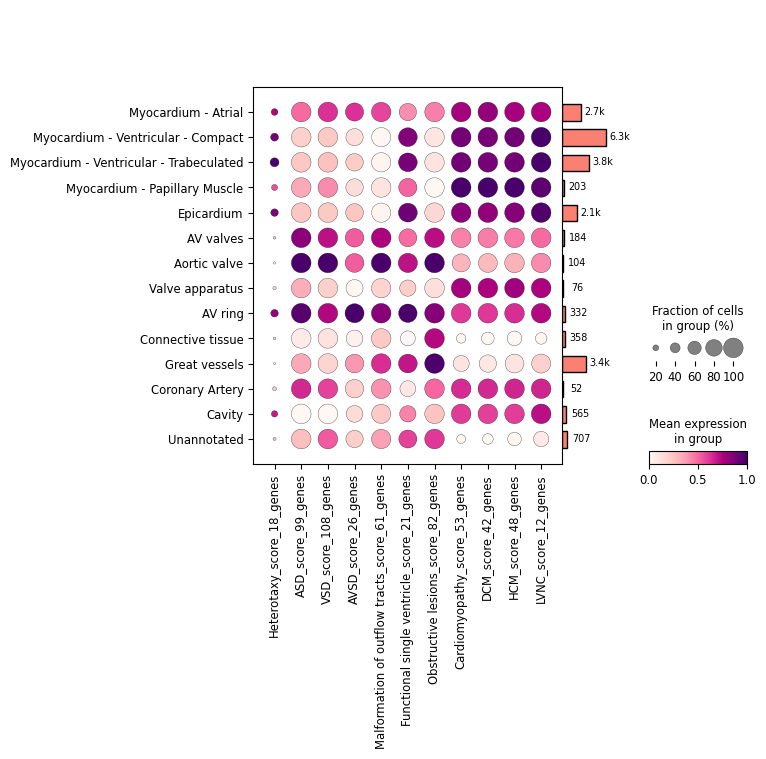

In [144]:
dp=sc.pl.dotplot(adata_vis,
                  var_names=list_of_scores,
                 groupby='JC_edit',
                 standard_scale='var',
                return_fig=True,
                cmap='RdPu')
dp.add_totals().show()

/home/jovyan/my-conda-envs/sqpy/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


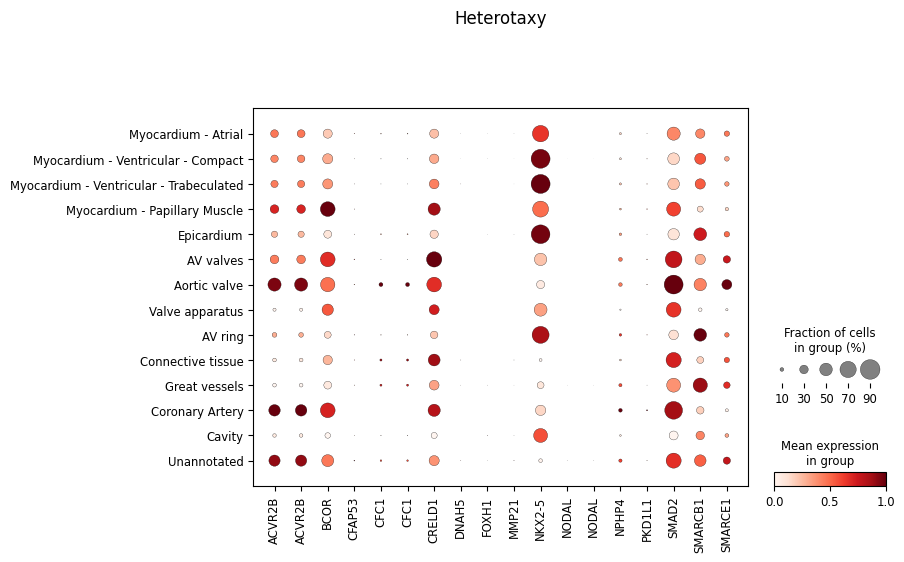

/home/jovyan/my-conda-envs/sqpy/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


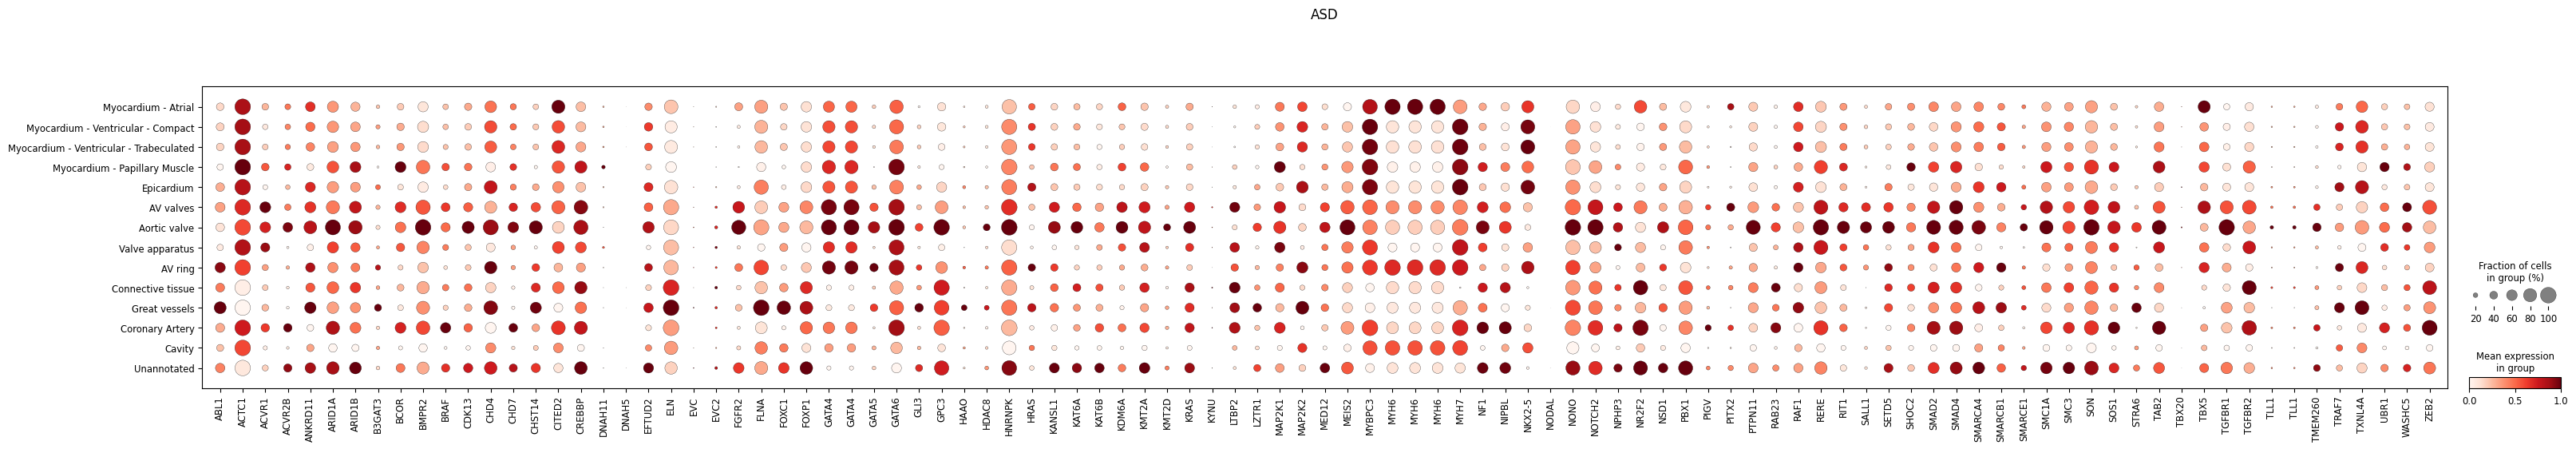

/home/jovyan/my-conda-envs/sqpy/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


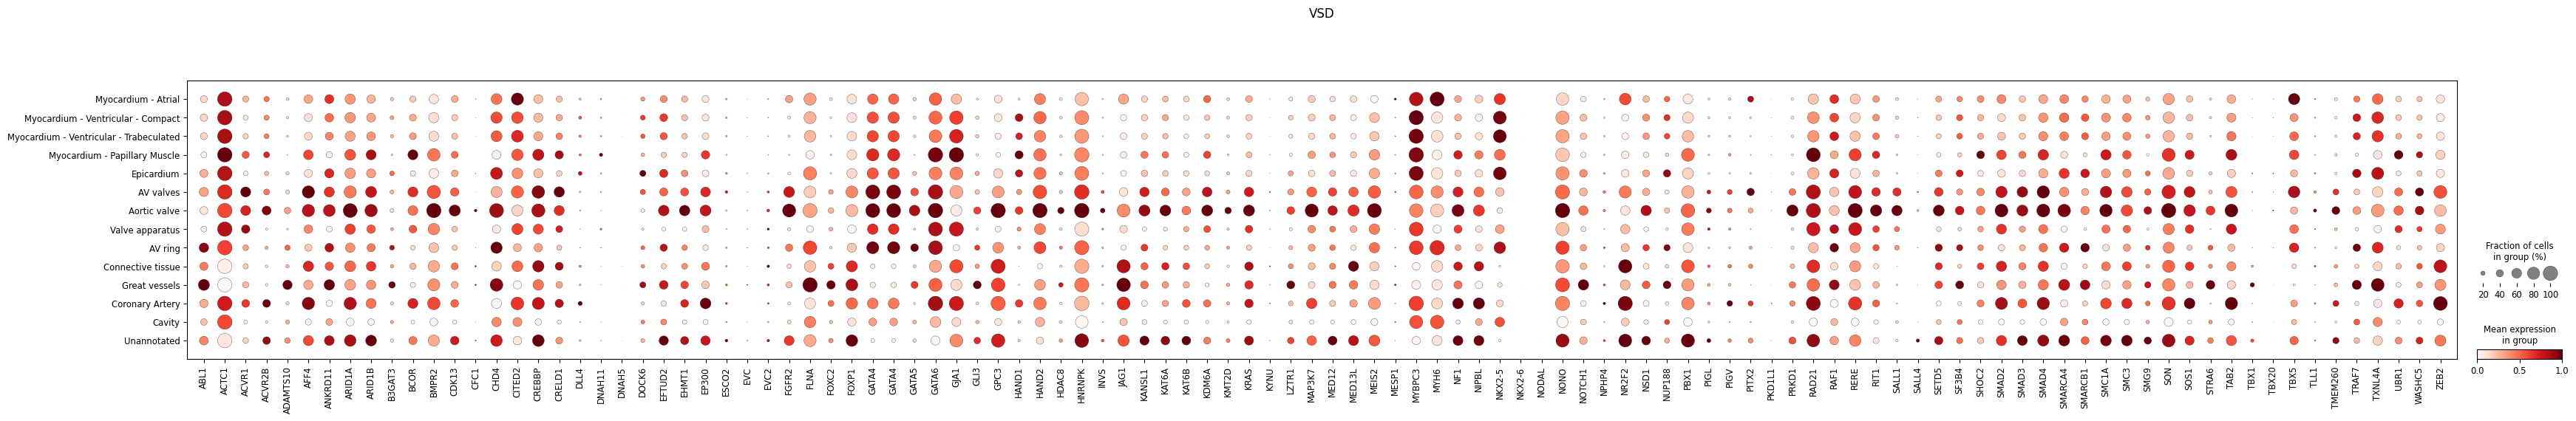

/home/jovyan/my-conda-envs/sqpy/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


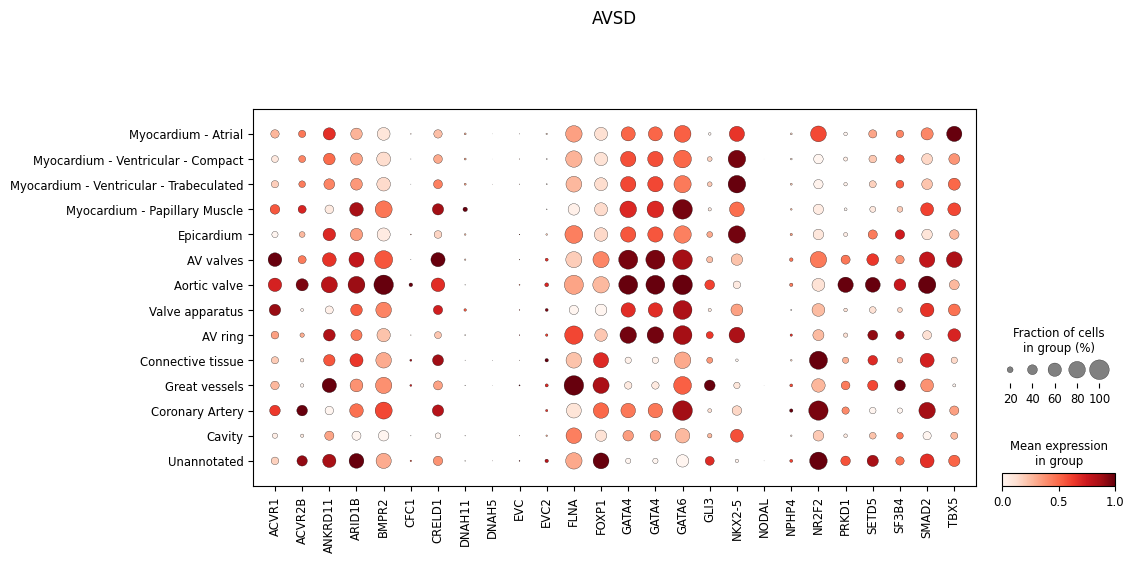

/home/jovyan/my-conda-envs/sqpy/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


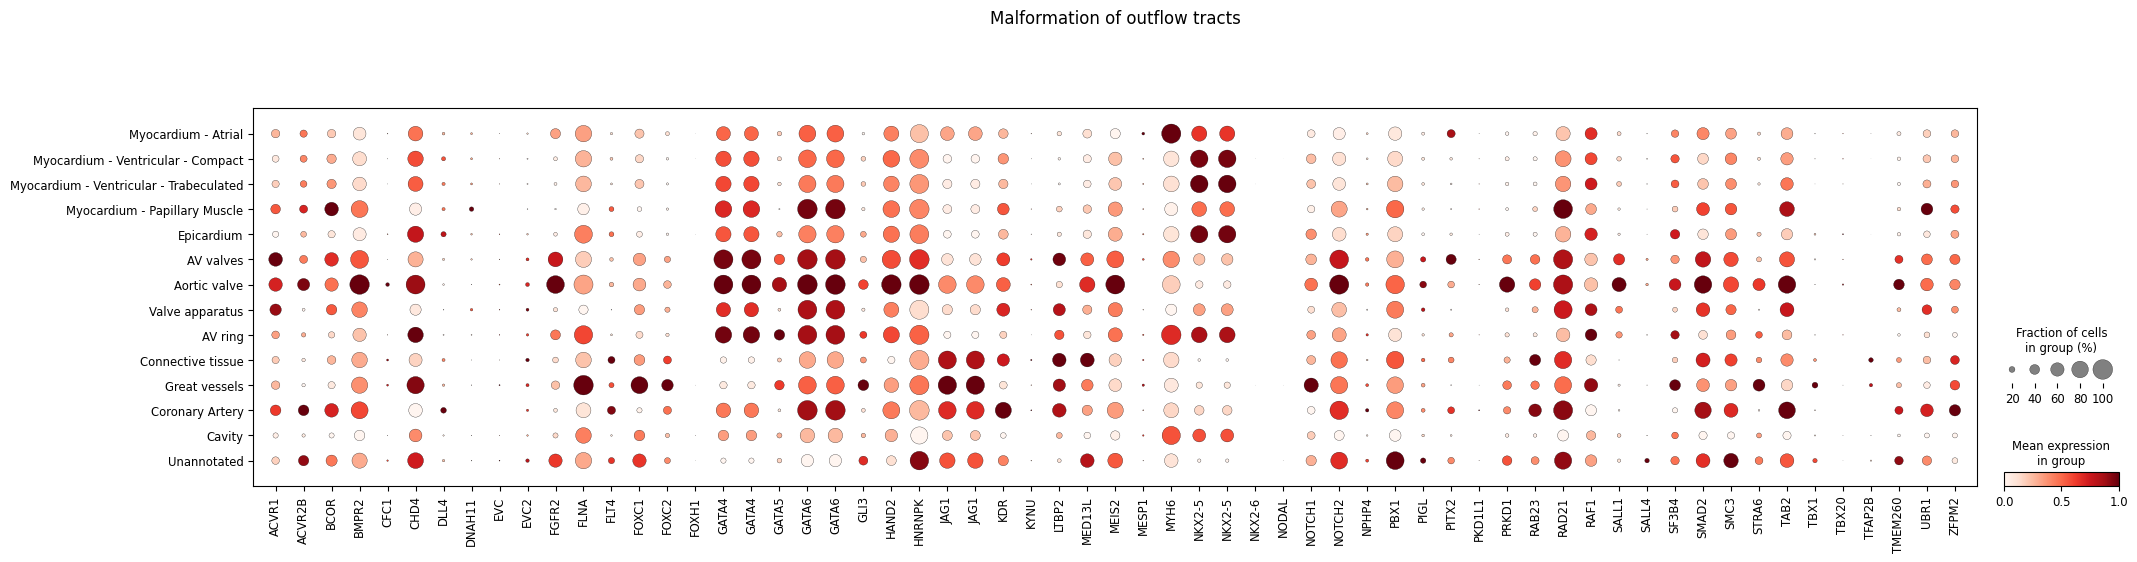

/home/jovyan/my-conda-envs/sqpy/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


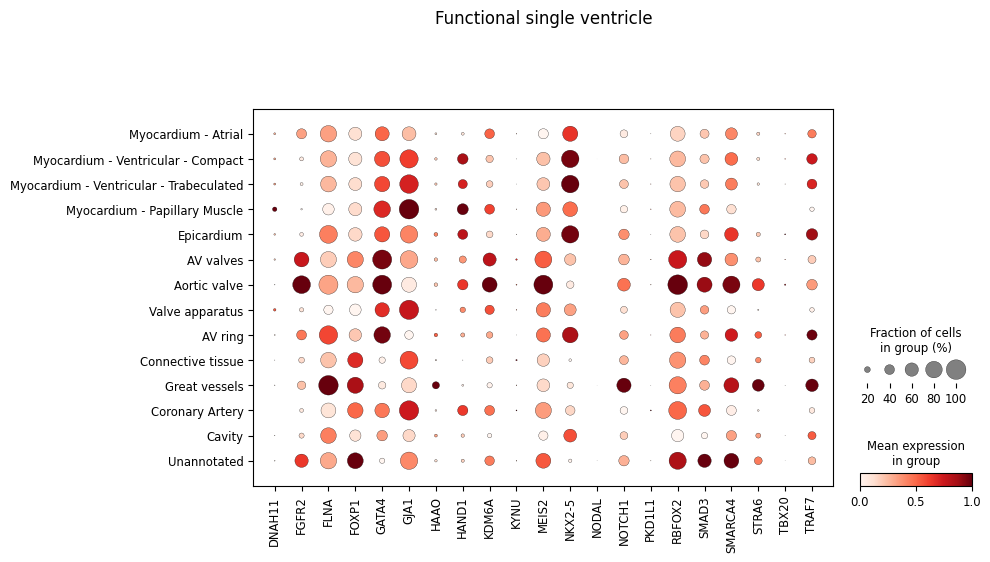

/home/jovyan/my-conda-envs/sqpy/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


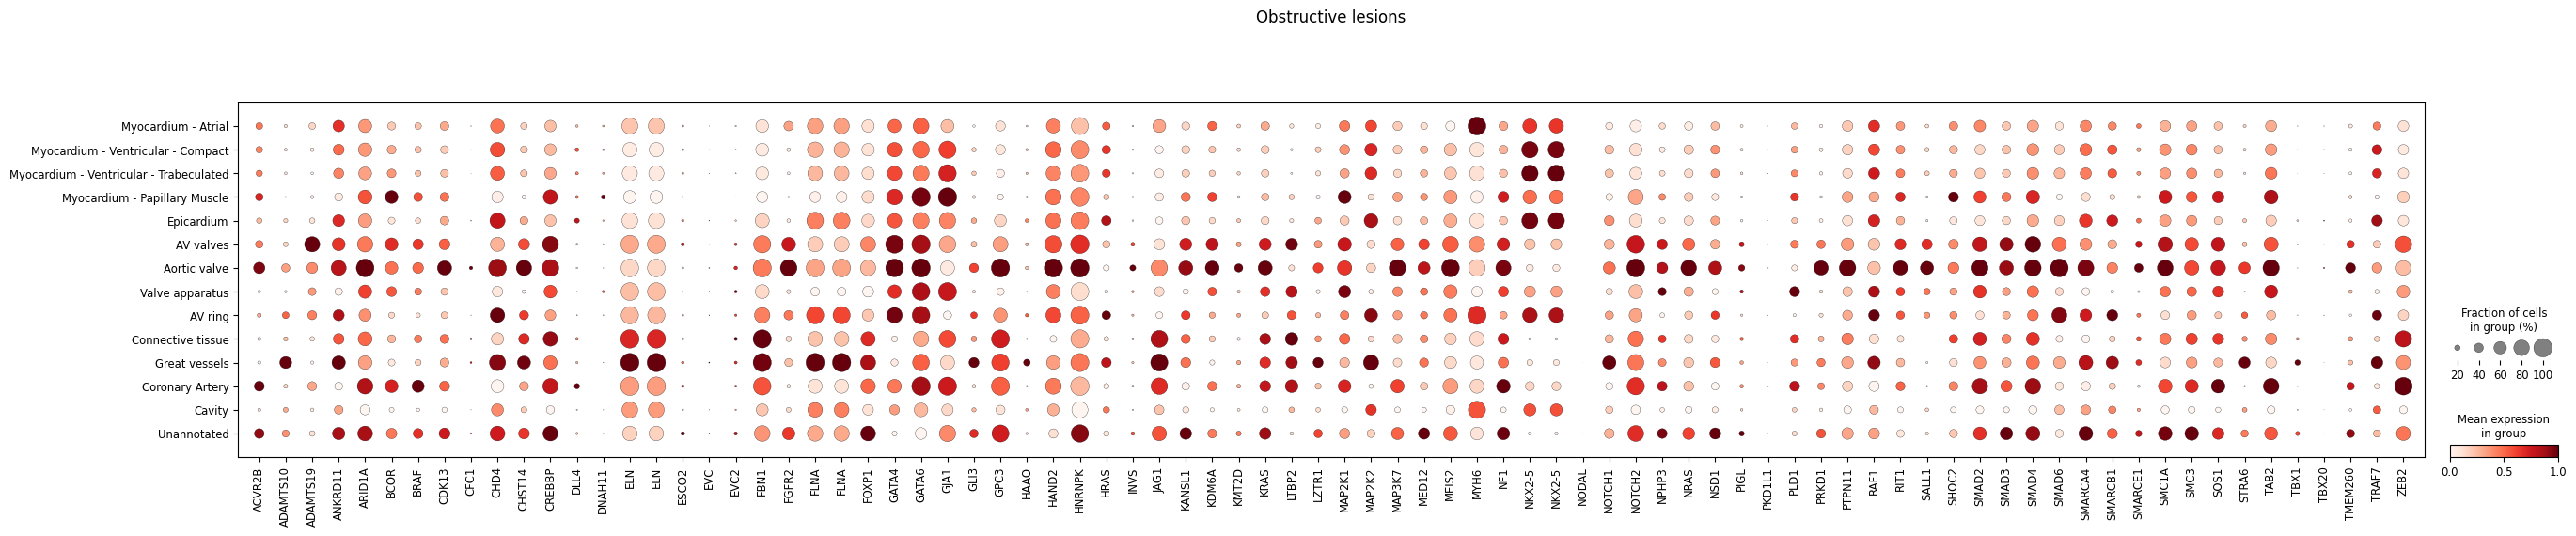

/home/jovyan/my-conda-envs/sqpy/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


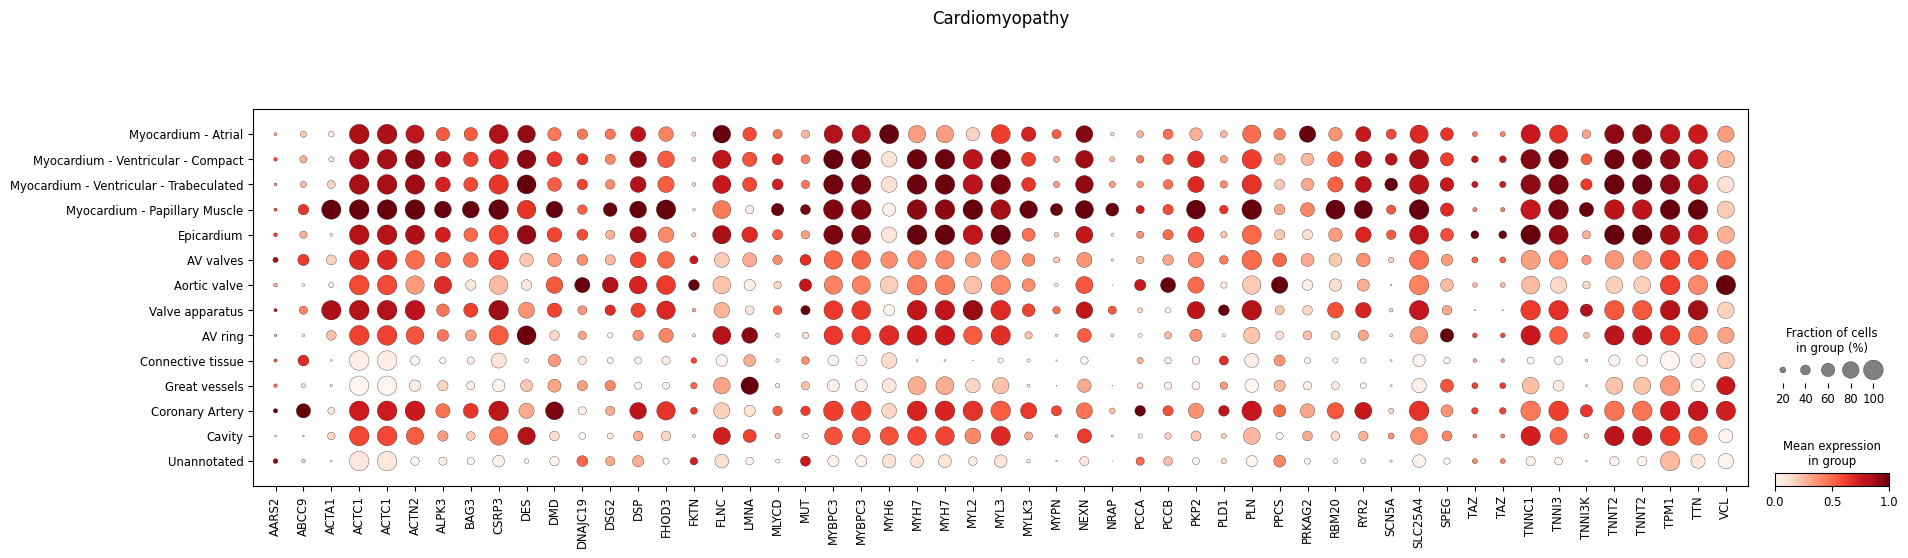

/home/jovyan/my-conda-envs/sqpy/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


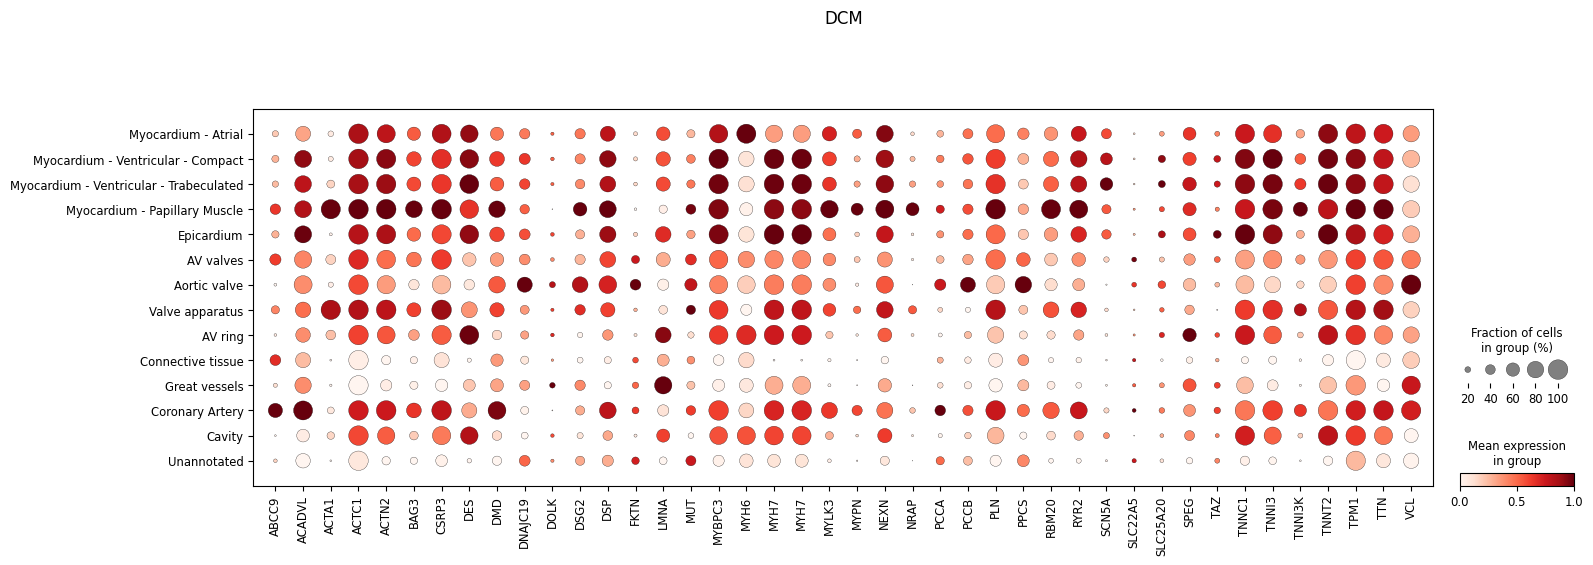

/home/jovyan/my-conda-envs/sqpy/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


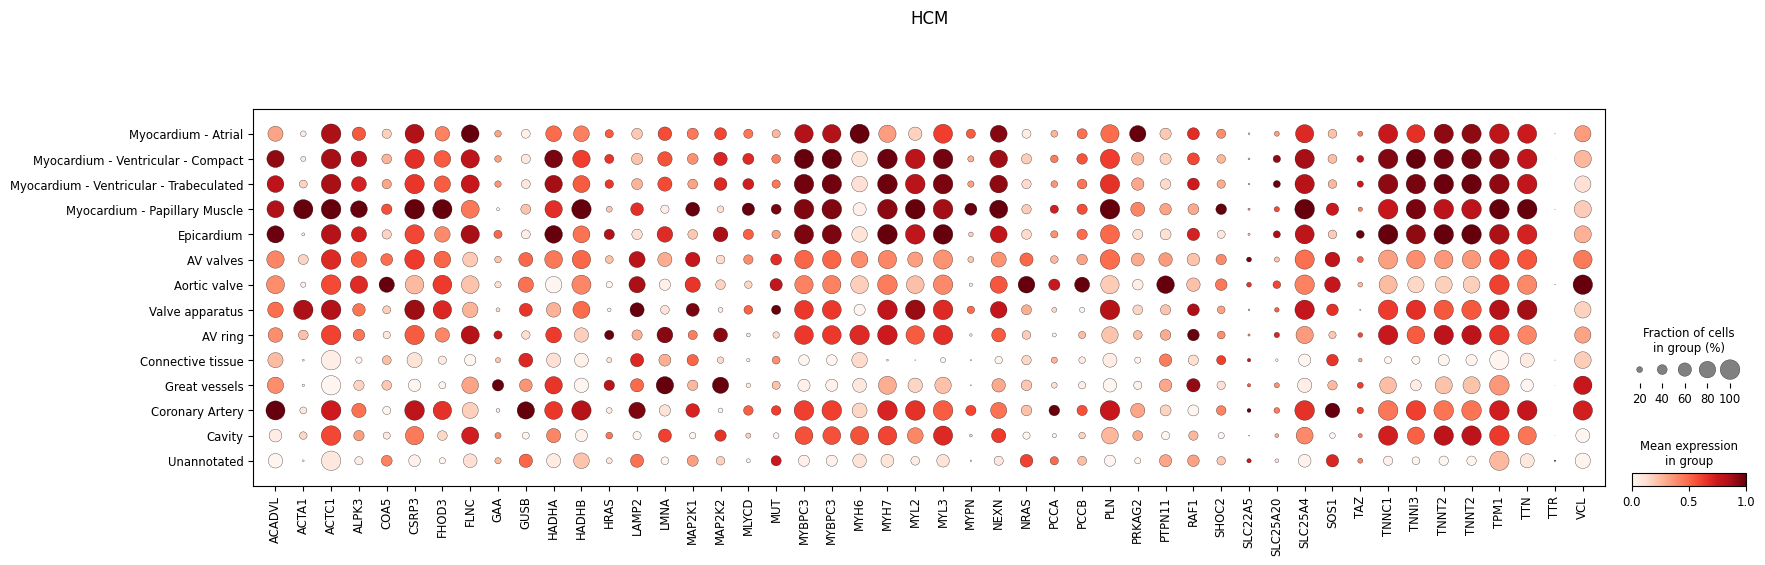

/home/jovyan/my-conda-envs/sqpy/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


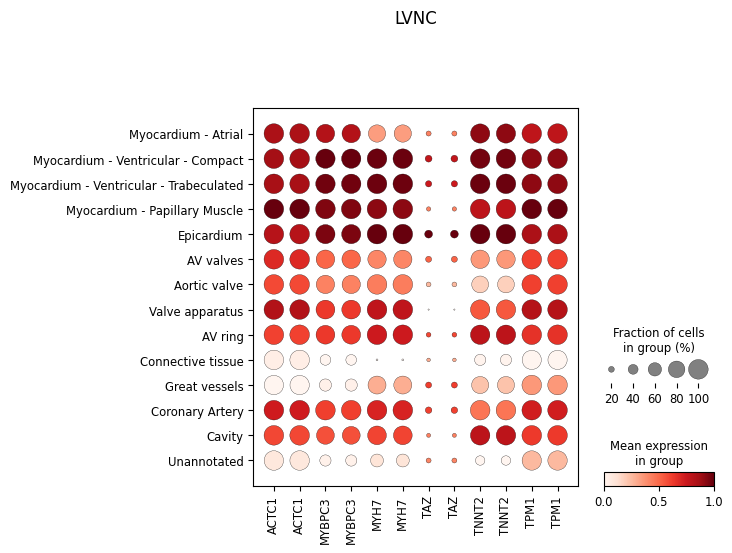

In [145]:
phenotypes=list(phenotype_dict.keys())

for phenotype in phenotypes:
    var_names=list(causal_genes.index[causal_genes[f'phenotype_{phenotype}']==1])
    sc.pl.dotplot(adata_vis,
                  groupby='JC_edit',
                  var_names=var_names,
                  title=phenotype,
                  standard_scale='var')

# Spatial Plot

In [146]:
list_of_scores.append('JC_edit')
list_of_scores

['Heterotaxy_score_18_genes',
 'ASD_score_99_genes',
 'VSD_score_108_genes',
 'AVSD_score_26_genes',
 'Malformation of outflow tracts_score_61_genes',
 'Functional single ventricle_score_21_genes',
 'Obstructive lesions_score_82_genes',
 'Cardiomyopathy_score_53_genes',
 'DCM_score_42_genes',
 'HCM_score_48_genes',
 'LVNC_score_12_genes',
 'JC_edit']

In [147]:
# Modified `select_slide` in cell2loc for multiple slides

# @param adata: anndata object with multiple spatial experiments
# @param s: list of selected slides
# @param s_col: column in adata.obs listing experiment name for each location

def select_multislide(adata, s, s_col='sample'):

    slides = adata[adata.obs[s_col].isin(s), :]
    s_keys = list(slides.uns['spatial'].keys())
    
    uns_dict = {}
    for ss in s:
        s_spatial=np.array(s_keys)[[ss in k for k in s_keys]][0]
        uns_dict[s_spatial]=slides.uns['spatial'][s_spatial]
    
    slides.uns['spatial'] = uns_dict

    return slides

In [148]:
slide_names=adata_vis.obs['sample'].unique().tolist()

In [149]:
list_of_slides=[]

for slide in slide_names:
    list_of_slides.append(select_multislide(adata_vis,s=[slide]))

/home/jovyan/my-conda-envs/sqpy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/jovyan/my-conda-envs/sqpy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/jovyan/my-conda-envs/sqpy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/jovyan/my-conda-envs/sqpy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/jovyan/my-conda-envs/sqpy/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.

In [137]:
slide.obs['Cardiofibromyocytes']

spot_id
HCAHeartST10298114_AAACAAGTATCTCCCA-1    0.010339
HCAHeartST10298114_AAACATTTCCCGGATT-1    0.003694
HCAHeartST10298114_AAACGAGACGGTTGAT-1    0.004626
HCAHeartST10298114_AAACTCGTGATATAAG-1    0.005162
HCAHeartST10298114_AAACTGCTGGCTCCAA-1    0.004643
                                           ...   
HCAHeartST10298114_TTGGGCGGCGGTTGCC-1    0.002479
HCAHeartST10298114_TTGTGAACCTAATCCG-1    0.004245
HCAHeartST10298114_TTGTGGCCCTGACAGT-1    0.005432
HCAHeartST10298114_TTGTGGTGGTACTAAG-1    0.004536
HCAHeartST10298114_TTGTTGTGTGTCAAGA-1    0.003481
Name: Cardiofibromyocytes, Length: 854, dtype: float64

In [135]:
slide=list_of_slides[0]
slide

AnnData object with n_obs × n_vars = 854 × 23016
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'n_counts', 'n_genes', 'JC_edit', 'sangerID', 'Foetal_or_Adult', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'AtrialCardiomyocytesCycling', 'AtrialCardiomyocytesLeft', 'AtrialCardiomyocytesRight', 'AtrioventricularNodeCardiomyocytes', 'BCells', 'Cardiofibromyocytes', 'ChromaffinCells', 'CoronaryEndothelialCellsArterial', 'CoronaryEndothelialCellsCapillary', 'CoronaryEndothelialCellsVenous', 'CoronaryPericytes', 'CoronarySmoothMuscleCells', 'CoronaryVesselAdventitialFibroblasts', 'DendriticCells', 'EndocardialCells', 'FibroblasticEpicardialCells', 'GreatVesselAdventi

HCAHeartST10298114


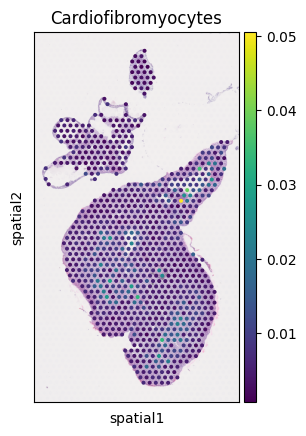

HCAHeartST10298115


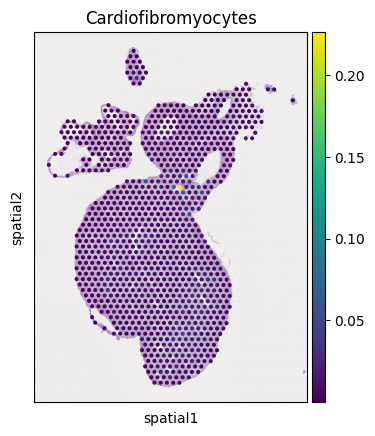

HCAHeartST10298116


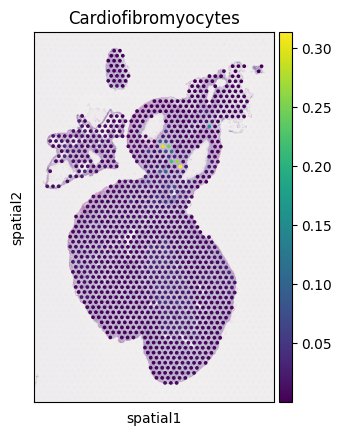

HCAHeartST10298117


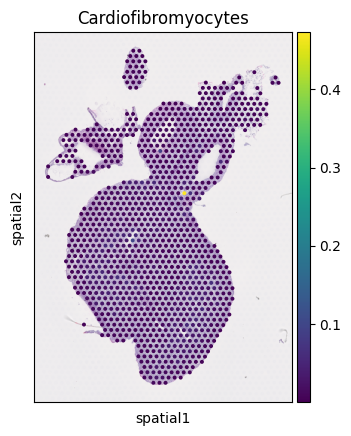

HCAHeartST10298118


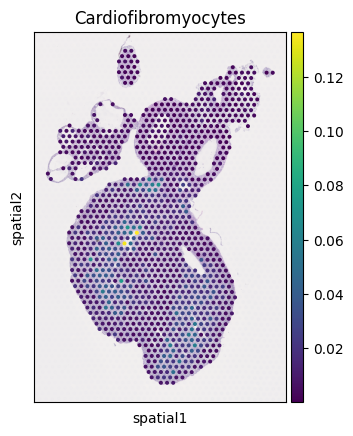

HCAHeartST10298119


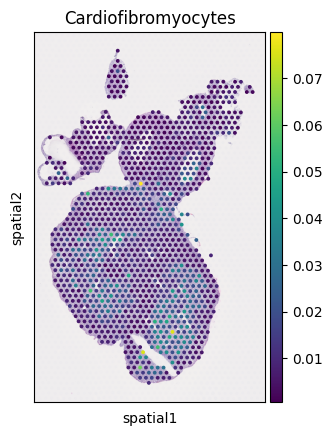

HCAHeartST10298120


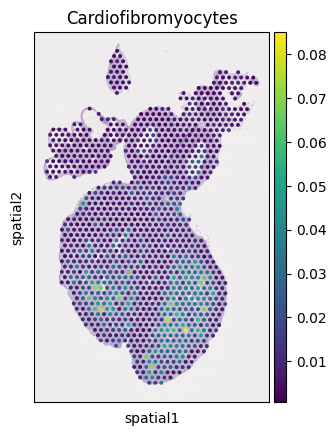

HCAHeartST10298121


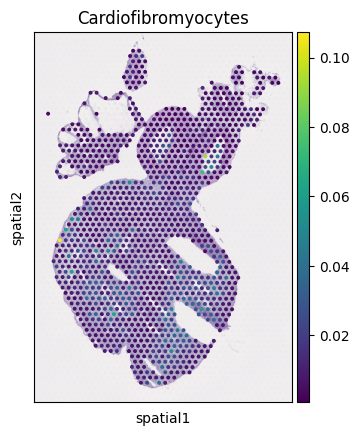

HCAHeartST10317184


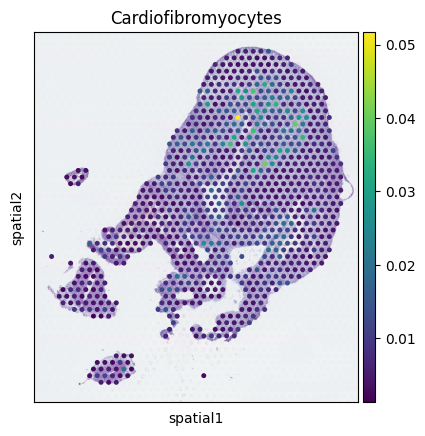

HCAHeartST10317185


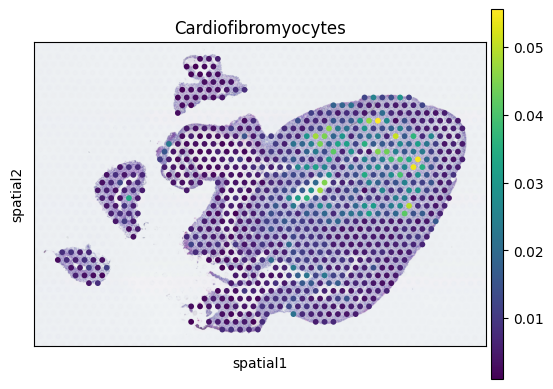

HCAHeartST10317186


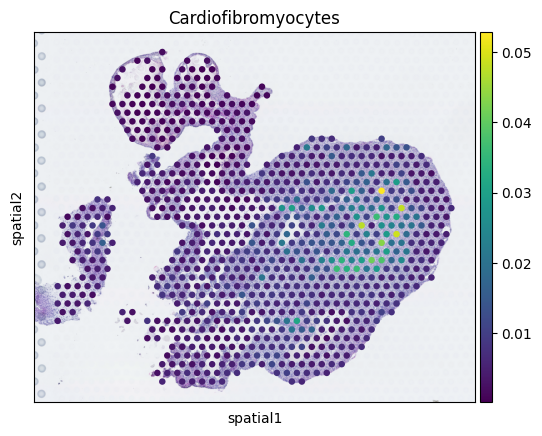

HCAHeartST10317187


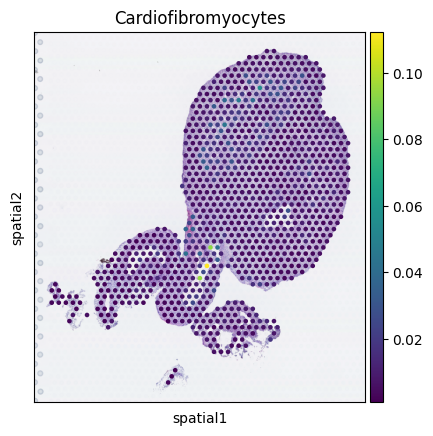

HCAHeartST10317188


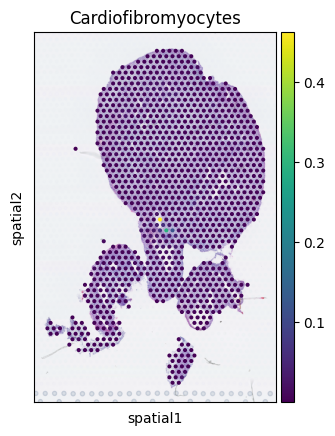

HCAHeartST10317189


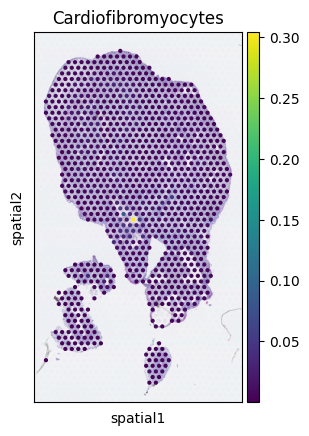

HCAHeartST10317190


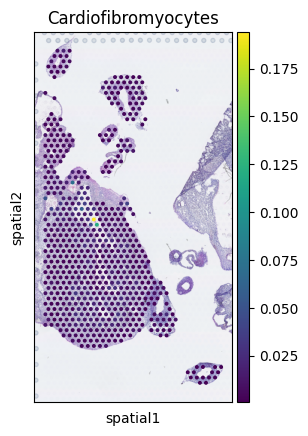

HCAHeartST11605165


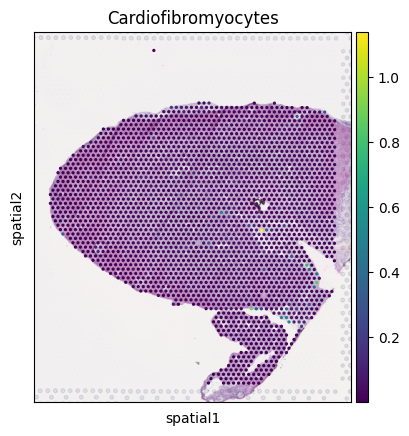

HCAHeartST11605166


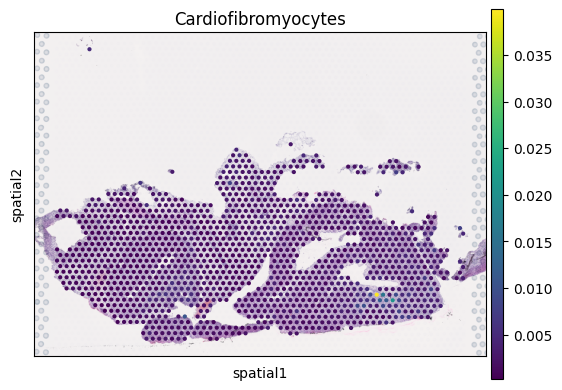

HCAHeartST11605167


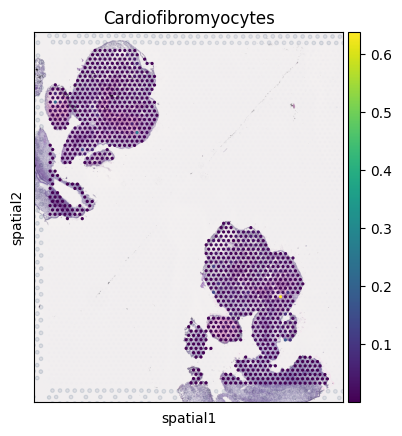

HCAHeartST11605168


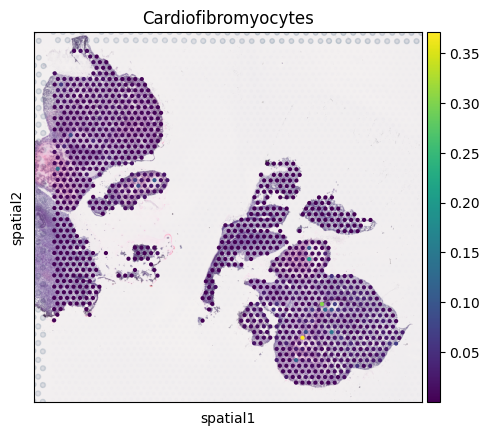

In [150]:
for slide in range(len(list_of_slides)):
    print(slide_names[slide])
    sc.pl.spatial(list_of_slides[slide],color='Cardiofibromyocytes')